In [81]:
# 7회 환경 데이터 기반 농작물 수확률 예측
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [84]:
# 문제01
from sklearn.linear_model import Lasso

In [85]:
# 문제02
crop_df = pd.read_csv("data/7_crop_yield_prediction.csv")
crop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   annual_rainfall_mm        900 non-null    float64
 1   avg_temp                  879 non-null    float64
 2   sunshine_hours            870 non-null    float64
 3   soil_type                 900 non-null    object 
 4   soil_ph                   900 non-null    float64
 5   fertilizer_type           900 non-null    object 
 6   nitrogen_concentration    900 non-null    float64
 7   phosphorus_concentration  900 non-null    float64
 8   potassium_concentration   900 non-null    float64
 9   yield_kg_per_ha           900 non-null    float64
dtypes: float64(8), object(2)
memory usage: 70.4+ KB


<Axes: xlabel='yield_kg_per_ha', ylabel='Count'>

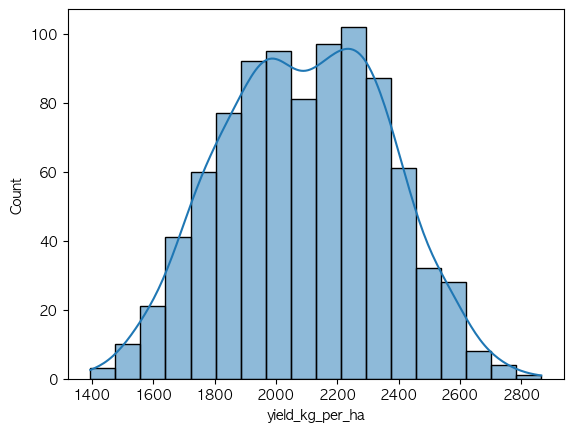

In [86]:
# 문제03
sns.histplot(data=crop_df, x='yield_kg_per_ha', kde=True) #오답

In [87]:
import platform
from matplotlib import rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False

<Axes: xlabel='soil_type', ylabel='yield_kg_per_ha'>

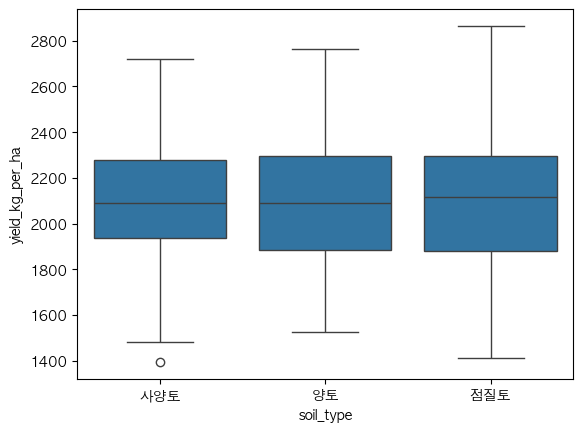

In [88]:
# 문제04
sns.boxplot(data=crop_df, x='soil_type', y='yield_kg_per_ha')

In [89]:
med = crop_df.groupby('soil_type')['yield_kg_per_ha'].median()
print(med) # 오답

soil_type
사양토    2092.0
양토     2092.0
점질토    2117.0
Name: yield_kg_per_ha, dtype: float64


In [90]:
# 문제05
crop_df.groupby('fertilizer_type')[['nitrogen_concentration','phosphorus_concentration','potassium_concentration']].mean() # 오답

,nitrogen_concentration,phosphorus_concentration,potassium_concentration
fertilizer_type,,,
복합,55.314223,27.543147,27.848207
인,55.079120,28.144352,28.286065
질소,54.204813,26.920000,27.679486
칼륨,54.856438,25.033196,27.129498


In [91]:
# 문제06
crop_pre = crop_df.copy()
null_col = ['avg_temp','sunshine_hours']
for col in null_col:
    mean = crop_pre[col].mean()
    crop_pre[col].fillna(mean, inplace=True)

crop_pre.isnull().sum()

annual_rainfall_mm          0
avg_temp                    0
sunshine_hours              0
soil_type                   0
soil_ph                     0
fertilizer_type             0
nitrogen_concentration      0
phosphorus_concentration    0
potassium_concentration     0
yield_kg_per_ha             0
dtype: int64

In [92]:
# 문제07
crop_pre.head()

,annual_rainfall_mm,avg_temp,sunshine_hours,soil_type,soil_ph,fertilizer_type,nitrogen_concentration,phosphorus_concentration,potassium_concentration,yield_kg_per_ha
0,1760.0,22.1,2698.0,사양토,6.9,질소,35.95,33.37,34.39,2422.0
1,656.0,22.8,1546.0,사양토,5.2,복합,23.64,31.49,10.71,1708.0
2,821.0,12.7,2346.0,양토,6.3,칼륨,45.34,30.08,5.47,1811.0
3,1461.0,24.1,2451.0,점질토,7.5,인,25.66,10.42,19.26,2025.0
4,503.0,22.8,2442.0,사양토,5.4,인,16.74,24.89,44.89,1568.0


In [93]:
# 1. fertilizer_type 은 get_dummies 사용하여 원-핫 인코딩
dummies = pd.get_dummies(crop_pre['fertilizer_type'], prefix='fertilizer')
crop_pre = pd.concat([crop_pre.drop('fertilizer_type', axis=1), dummies], axis=1)

# 2. soil_type 은 LabelEncoder 사용하여 레이블 인코딩 수행
le = LabelEncoder()
crop_pre['soil_type'] = le.fit_transform(crop_pre['soil_type'])

In [94]:
crop_pre

,annual_rainfall_mm,avg_temp,sunshine_hours,soil_type,soil_ph,nitrogen_concentration,phosphorus_concentration,potassium_concentration,yield_kg_per_ha,fertilizer_복합,fertilizer_인,fertilizer_질소,fertilizer_칼륨
0,1760.0,22.1,2698.0,0,6.9,35.95,33.37,34.39,2422.0,False,False,True,False
1,656.0,22.8,1546.0,0,5.2,23.64,31.49,10.71,1708.0,True,False,False,False
2,821.0,12.7,2346.0,1,6.3,45.34,30.08,5.47,1811.0,False,False,False,True
3,1461.0,24.1,2451.0,2,7.5,25.66,10.42,19.26,2025.0,False,True,False,False
4,503.0,22.8,2442.0,0,5.4,16.74,24.89,44.89,1568.0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,1769.0,15.4,1629.0,0,6.6,94.37,28.49,32.92,2497.0,True,False,False,False
896,1349.0,20.3,2820.0,2,6.6,42.50,44.42,6.91,2388.0,False,False,True,False
897,1301.0,12.6,2486.0,1,7.3,37.92,16.36,40.04,2306.0,True,False,False,False
898,1873.0,13.0,2370.0,1,6.3,77.49,23.33,33.72,2426.0,False,False,False,True


In [95]:
# 문제08
crop_pre['nitro_potassium_ratio'] = np.where(
    crop_pre['potassium_concentration'] == 0,
    0,
    crop_pre['nitrogen_concentration'] / crop_pre['potassium_concentration']
)

In [96]:
crop_pre

,annual_rainfall_mm,avg_temp,sunshine_hours,soil_type,soil_ph,nitrogen_concentration,phosphorus_concentration,potassium_concentration,yield_kg_per_ha,fertilizer_복합,fertilizer_인,fertilizer_질소,fertilizer_칼륨,nitro_potassium_ratio
0,1760.0,22.1,2698.0,0,6.9,35.95,33.37,34.39,2422.0,False,False,True,False,1.045362
1,656.0,22.8,1546.0,0,5.2,23.64,31.49,10.71,1708.0,True,False,False,False,2.207283
2,821.0,12.7,2346.0,1,6.3,45.34,30.08,5.47,1811.0,False,False,False,True,8.288848
3,1461.0,24.1,2451.0,2,7.5,25.66,10.42,19.26,2025.0,False,True,False,False,1.332295
4,503.0,22.8,2442.0,0,5.4,16.74,24.89,44.89,1568.0,False,True,False,False,0.372912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,1769.0,15.4,1629.0,0,6.6,94.37,28.49,32.92,2497.0,True,False,False,False,2.866646
896,1349.0,20.3,2820.0,2,6.6,42.50,44.42,6.91,2388.0,False,False,True,False,6.150507
897,1301.0,12.6,2486.0,1,7.3,37.92,16.36,40.04,2306.0,True,False,False,False,0.947053
898,1873.0,13.0,2370.0,1,6.3,77.49,23.33,33.72,2426.0,False,False,False,True,2.298043


In [97]:
# 문제09
X = crop_pre.drop(['yield_kg_per_ha'], axis=1)
y = crop_pre['yield_kg_per_ha']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2024)
print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)

(720, 13) (180, 13)
(720,) (180,)


In [98]:
# 문제10
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [99]:
# 문제11
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.5, random_state=2024)
model_lasso.fit(X_train_scaled, y_train)
lasso_pred = model_lasso.predict(X_valid_scaled)

In [100]:
# 문제12
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=150, max_depth=8, random_state=2024)
model_rf.fit(X_train_scaled, y_train)
rf_pred = model_rf.predict(X_valid_scaled)

In [101]:
# 문제13
from sklearn.metrics import mean_absolute_error, r2_score
lasso_mae = mean_absolute_error(lasso_pred, y_valid)
lasso_r2 = r2_score(lasso_pred, y_valid)

rf_mae = mean_absolute_error(rf_pred, y_valid)
rf_r2 = r2_score(rf_pred, y_valid)

print(f"mae 비교 | Lasso : {lasso_mae:.4f}, rf : {rf_mae:.4f}")
print(f"r2 비교 | Lasso : {lasso_r2:.4f}, rf : {rf_r2:.4f}")

mae 비교 | Lasso : 90.8115, rf : 90.8695
r2 비교 | Lasso : 0.7330, rf : 0.7116


In [104]:
# 문제14
model_dl = Sequential([
    Dense(32, activation='relu', input_shape=[X_train.shape[1]]),
    Dense(16, activation='relu'),
    Dense(1)
])

model_dl.compile(optimizer='adam', loss='mean_squared_error')

model_dl.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data = (X_valid_scaled, y_valid),
    verbose = 0
)

new_crop_data = np.array([[1500, 20.0, 2500.0, 1, 6.5, 35.0, 30.0, 40.0, 1, 0, 0, 0, 0.875]])
new_crop_data_scaled = scaler.transform(new_crop_data)
predicted_yield_dl = model_dl.predict(new_crop_data_scaled)
predicted_yield_dl[0][0]

1/1 [==============================] - 0s 36ms/step


/opt/anaconda3/envs/aice/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


2183.5393